In [2]:
## 施設名のエンコーディング
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [3]:
class FacilityDataset(Dataset):
    def __init__(self, facilities, targets=None):
        self.facilities = facilities
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = 128

    def __len__(self):
        return len(self.facilities)

    def __getitem__(self, idx):
        facility = str(self.facilities[idx])
        inputs = self.tokenizer.encode_plus(
            facility,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[idx], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }
            
train_df = pd.read_csv('train.csv')
facilities = train_df['FacilityName'].values
train_dataset = FacilityDataset(facilities, train_df['GHG_Direct_Emissions_14_in_metric_tons'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [4]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, ids, mask, token_type_ids):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # BERTのプーリングされた出力を取得
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
def rmsle_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))

In [ ]:
model = BertRegressor()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            ids = batch['ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = batch['mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
            token_type_ids = batch['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = batch['targets'].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(ids, mask, token_type_ids)
            loss = rmsle_loss(outputs, targets.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(model, train_loader, optimizer, num_epochs=5)

## 本題

In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    # 負の値を調整
    y_pred[y_pred < 0] = 0
    
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [20]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]

In [21]:
train_df.sample(5)

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
1425,LYONDELL CHEMICAL CO BAYPORT FACILITY (PART),29.625384,-95.051502,10801 CHOATE RD,PASADENA,TX,77507,48201.0,325110,NaN,Chemicals,28023.030411,27741.036601,18777.134585,19071.029897,87629.120711,40902.599635,36729.412409,20205.019097,50871.102991
1737,FLORIDA POWER CORP ANCLOTE POWER PLANT,28.184215,-82.787895,1729 BAILEYS BLUFF ROAD,HOLIDAY,FL,34691-9753,12101.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,64672.888195,75203.375832,223000.703883,63742.779760,64022.348676
3675,BPXA GATHERING CENTER #2,70.310918,-148.862927,NaN,PRUDHOE BAY,AK,99734,2185.0,211111,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,76801.141988,19592.340926,49398.888332,57446.583282,52843.387000
2105,PUBLIC SERVICE COMPANY OF COLORADO CHEROKEE ST...,39.807769,-104.964802,6198 FRANKLIN ST,DENVER,CO,80216,8001.0,221112,NaN,Power Plants,25294.025051,38122.055403,31830.564969,30393.495614,77560.083870,74257.215454,74812.230558,41506.871458,50706.845450
3430,GEORGIA PACIFIC GYPSUM LLC- SAVANNAH,32.074700,-81.052360,151 WAHLSTROM RD,SAVANNAH,GA,31404,13051.0,327420,NaN,Minerals,NaN,NaN,NaN,NaN,75214.551329,46898.177924,48857.985054,74889.160348,63854.405989


In [22]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns) | set(lat_lon_columns) | set(target_columns))))

## 前処理

### targetの変更

In [23]:
# GHG_Direct_Emissions_13が欠損している行は別で予測する
train_df_without_13 = train_df[train_df['GHG_Direct_Emissions_13_in_metric_tons'].isnull()]
train_df = train_df.dropna(subset=['GHG_Direct_Emissions_13_in_metric_tons'])

test_df_without_13 = test_df[test_df['GHG_Direct_Emissions_13_in_metric_tons'].isnull()]
test_df = test_df.dropna(subset=['GHG_Direct_Emissions_13_in_metric_tons'])

# indexの付け替え
train_df = train_df.reset_index(drop=True)

In [38]:
# 新しいコラムを追加
new_columns = ['GHG_Direct_Emissions_Change_13_14']

# GHG_Direct_Emissions_14と_13の変化量を計算
train_df['GHG_Direct_Emissions_Change_13_14'] = train_df['GHG_Direct_Emissions_14_in_metric_tons'] / train_df['GHG_Direct_Emissions_13_in_metric_tons']

# target_columnsを変更
target_columns = ['GHG_Direct_Emissions_Change_13_14']

# target_columnsの欠損値がないことをチェック
assert train_df[target_columns].isnull().sum().sum() == 0

### City

In [25]:
# # target encoding for city column
# City_median = train_df.groupby('City').GHG_Direct_Emissions_14_in_metric_tons.median()
# train_df['City_median'] = train_df['City'].map(City_median)
# test_df['City_median'] = test_df['City'].map(City_median)

# # if city is not present in test data then fill it with global median
# test_df['City_median'] = test_df['City_median'].fillna(train_df.GHG_Direct_Emissions_14_in_metric_tons.median())
# numerical_columns.append('City_median')

In [26]:
def Holdout_target_encoding(train, test, target, categorical_columns, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=13)
    for col in tqdm(categorical_columns):
        train[col + '_enc'] = np.nan
        for train_index, valid_index in kf.split(train):
            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            means = X_valid[col].map(X_train.groupby(col)[target].mean())
            train.loc[valid_index, col + '_enc'] = means
        test[col + '_enc'] = test[col].map(train.groupby(col)[target].mean())
        test[col + '_enc'].fillna(train[target].mean(), inplace=True)
    return train, test
    
train_df, test_df = Holdout_target_encoding(train_df, test_df, target_columns[0], categorical_columns)
numerical_columns += [col + '_enc' for col in categorical_columns]

100%|██████████| 6/6 [00:00<00:00, 17.97it/s]


In [27]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique  = set(test_df[colname].unique())
    intersection = test_unique & train_unique
    return len(intersection)/test_df.shape[0]

In [28]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - LocationAddress has 1.0677618069815196% values in train data
column - City has 33.880903490759756% values in train data
column - ZIP has 20.985626283367555% values in train data
column - FacilityName has 3.6139630390143735% values in train data
column - State has 2.217659137577002% values in train data
column - IndustryType has 1.5605749486652978% values in train data


In [29]:
def create_features1(df):
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # Year-over-year growth rate
    df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [30]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                     'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']


train_df      = create_features2(train_df)
test_df       = create_features2(test_df)
new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 + new_features2

In [39]:
train = train_df[numerical_columns].values 
test  = test_df[numerical_columns].values 
target = train_df[target_columns].values

## Optuna

In [40]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1)
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        _ = model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        # 真の予測値はGHG_Direct_Emissions_13 * 予測値, shapeを合わせる
        score = root_mean_squared_log_error(y_valid.flatten() * train_df.loc[valid_index, 'GHG_Direct_Emissions_13_in_metric_tons'].values, valid_preds.flatten() * train_df.loc[valid_index, 'GHG_Direct_Emissions_13_in_metric_tons'].values)
        scores.append(score)
        
    print(f'RMSE: {np.mean(scores)}')
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_params = study.best_params
optuna_params['random_state'] = 13
optuna_params['verbose'] = -1

    

[I 2024-11-06 08:11:45,576] A new study created in memory with name: no-name-da028fb5-8fc0-4ab1-9e09-2ce96ca6da7b
[I 2024-11-06 08:11:48,765] Trial 0 finished with value: 4.086732089099344 and parameters: {'n_estimators': 507, 'learning_rate': 0.07588254097644191, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.6414342092356422, 'colsample_bytree': 0.783257319938534, 'reg_alpha': 0.0019190396161803337, 'reg_lambda': 0.22609474611146183}. Best is trial 0 with value: 4.086732089099344.


RMSE: 4.086732089099344


[I 2024-11-06 08:11:53,870] Trial 1 finished with value: 1.2165312283594325 and parameters: {'n_estimators': 716, 'learning_rate': 0.00010419878329982345, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 90, 'subsample': 0.8949171201568895, 'colsample_bytree': 0.7947592579856675, 'reg_alpha': 0.017224330590635294, 'reg_lambda': 0.0005851636334605086}. Best is trial 1 with value: 1.2165312283594325.


RMSE: 1.2165312283594325


[I 2024-11-06 08:11:57,522] Trial 2 finished with value: 1.1881649069354208 and parameters: {'n_estimators': 881, 'learning_rate': 0.00017281304972284773, 'num_leaves': 290, 'max_depth': 5, 'min_child_samples': 89, 'subsample': 0.8542629480083004, 'colsample_bytree': 0.9746800523398798, 'reg_alpha': 0.000161250004319742, 'reg_lambda': 0.06251519606304298}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 1.1881649069354208


[I 2024-11-06 08:12:01,873] Trial 3 finished with value: 1.235391388181795 and parameters: {'n_estimators': 712, 'learning_rate': 5.204422501197352e-05, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 63, 'subsample': 0.6501783985009637, 'colsample_bytree': 0.5337709781920089, 'reg_alpha': 0.060033114740039834, 'reg_lambda': 6.479167875926076}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 1.235391388181795


[I 2024-11-06 08:12:08,689] Trial 4 finished with value: 3.7035646417656123 and parameters: {'n_estimators': 514, 'learning_rate': 0.047982613496795536, 'num_leaves': 192, 'max_depth': 11, 'min_child_samples': 31, 'subsample': 0.6979766253626924, 'colsample_bytree': 0.8036917219593084, 'reg_alpha': 1.0641207856169317, 'reg_lambda': 0.0779496453476757}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 3.7035646417656123


[I 2024-11-06 08:12:11,141] Trial 5 finished with value: 1.2411548733200868 and parameters: {'n_estimators': 871, 'learning_rate': 1.941437696528286e-05, 'num_leaves': 293, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.9278726484416878, 'colsample_bytree': 0.5140552832142409, 'reg_alpha': 0.00011451439470649331, 'reg_lambda': 0.00021965144789547268}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 1.2411548733200868


[I 2024-11-06 08:12:12,307] Trial 6 finished with value: 1.2197853698804224 and parameters: {'n_estimators': 460, 'learning_rate': 0.00018322480328526294, 'num_leaves': 133, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.9310174902044087, 'colsample_bytree': 0.5391394175513308, 'reg_alpha': 0.00011762797032926091, 'reg_lambda': 0.16854167462483935}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 1.2197853698804224


[I 2024-11-06 08:12:18,551] Trial 7 finished with value: 1.2076518449718616 and parameters: {'n_estimators': 765, 'learning_rate': 0.0001330023884793819, 'num_leaves': 282, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7218669532931514, 'colsample_bytree': 0.6936066221388699, 'reg_alpha': 0.028351220361758918, 'reg_lambda': 0.001552811370305948}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 1.2076518449718616


[I 2024-11-06 08:12:25,399] Trial 8 finished with value: 4.0466870257565235 and parameters: {'n_estimators': 857, 'learning_rate': 0.049251644719159986, 'num_leaves': 275, 'max_depth': 10, 'min_child_samples': 90, 'subsample': 0.6580027236236149, 'colsample_bytree': 0.8372195024491329, 'reg_alpha': 0.005614017726126549, 'reg_lambda': 0.004475284496158478}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 4.0466870257565235


[I 2024-11-06 08:12:33,145] Trial 9 finished with value: 4.0817794574404385 and parameters: {'n_estimators': 794, 'learning_rate': 0.03028426815417281, 'num_leaves': 188, 'max_depth': 12, 'min_child_samples': 49, 'subsample': 0.5578818852457782, 'colsample_bytree': 0.6892305160048788, 'reg_alpha': 0.16419446305988253, 'reg_lambda': 0.030149897327250236}. Best is trial 2 with value: 1.1881649069354208.


RMSE: 4.0817794574404385


[I 2024-11-06 08:12:33,867] Trial 10 finished with value: 1.0808469001050889 and parameters: {'n_estimators': 142, 'learning_rate': 0.004505826657292614, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 99, 'subsample': 0.8281388100343562, 'colsample_bytree': 0.9921458461628395, 'reg_alpha': 8.277967616326217, 'reg_lambda': 2.8710222625321067}. Best is trial 10 with value: 1.0808469001050889.


RMSE: 1.0808469001050889


[I 2024-11-06 08:12:35,351] Trial 11 finished with value: 1.134485212988915 and parameters: {'n_estimators': 130, 'learning_rate': 0.002771603229751232, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 99, 'subsample': 0.8185482132757679, 'colsample_bytree': 0.992398188352697, 'reg_alpha': 3.861600671811088, 'reg_lambda': 5.507977916510842}. Best is trial 10 with value: 1.0808469001050889.


RMSE: 1.134485212988915


[I 2024-11-06 08:12:36,004] Trial 12 finished with value: 1.1029988948062477 and parameters: {'n_estimators': 118, 'learning_rate': 0.004283400572939202, 'num_leaves': 23, 'max_depth': 6, 'min_child_samples': 74, 'subsample': 0.8095208450687554, 'colsample_bytree': 0.986873782458482, 'reg_alpha': 6.5648767058275075, 'reg_lambda': 6.1776434656409265}. Best is trial 10 with value: 1.0808469001050889.


RMSE: 1.1029988948062477


[I 2024-11-06 08:12:36,356] Trial 13 finished with value: 1.156574682195719 and parameters: {'n_estimators': 101, 'learning_rate': 0.0037486015197935115, 'num_leaves': 76, 'max_depth': 3, 'min_child_samples': 73, 'subsample': 0.8119997289262751, 'colsample_bytree': 0.9064192307299852, 'reg_alpha': 6.42901824106364, 'reg_lambda': 1.6042929844995806}. Best is trial 10 with value: 1.0808469001050889.


RMSE: 1.156574682195719


[I 2024-11-06 08:12:37,662] Trial 14 finished with value: 0.9744170517955221 and parameters: {'n_estimators': 303, 'learning_rate': 0.010044854142010956, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 79, 'subsample': 0.9982446352803747, 'colsample_bytree': 0.9117285885135283, 'reg_alpha': 0.557755845711488, 'reg_lambda': 0.9783354413534056}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 0.9744170517955221


[I 2024-11-06 08:12:38,993] Trial 15 finished with value: 0.9809275327060554 and parameters: {'n_estimators': 300, 'learning_rate': 0.013512627538079226, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 77, 'subsample': 0.9847002746075841, 'colsample_bytree': 0.8998469266940978, 'reg_alpha': 0.5575981651567173, 'reg_lambda': 0.8181520288570836}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 0.9809275327060554


[I 2024-11-06 08:12:40,769] Trial 16 finished with value: 1.0347293354227391 and parameters: {'n_estimators': 309, 'learning_rate': 0.014610715656425393, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 76, 'subsample': 0.9967826856682472, 'colsample_bytree': 0.8921587873560322, 'reg_alpha': 0.3597141287421139, 'reg_lambda': 0.6943117376583714}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 1.0347293354227391


[I 2024-11-06 08:12:42,355] Trial 17 finished with value: 1.1714331237458953 and parameters: {'n_estimators': 294, 'learning_rate': 0.0006846234022017621, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 49, 'subsample': 0.9845708585997333, 'colsample_bytree': 0.8964630639489293, 'reg_alpha': 0.6422505706554786, 'reg_lambda': 0.01662950700279435}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 1.1714331237458953


[I 2024-11-06 08:12:45,754] Trial 18 finished with value: 1.6065336813785618 and parameters: {'n_estimators': 373, 'learning_rate': 0.014657850527055009, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.9563503961410795, 'colsample_bytree': 0.697315518100673, 'reg_alpha': 0.14881455128242185, 'reg_lambda': 0.579227536929476}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 1.6065336813785618


[I 2024-11-06 08:12:47,706] Trial 19 finished with value: 1.0828255537481273 and parameters: {'n_estimators': 617, 'learning_rate': 0.0011737280546118547, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 64, 'subsample': 0.5035878659468183, 'colsample_bytree': 0.8554343368720011, 'reg_alpha': 1.8579069885386892, 'reg_lambda': 0.9225275079624332}. Best is trial 14 with value: 0.9744170517955221.


RMSE: 1.0828255537481273


[I 2024-11-06 08:12:49,258] Trial 20 finished with value: 0.9297610598058602 and parameters: {'n_estimators': 239, 'learning_rate': 0.014148234211691866, 'num_leaves': 173, 'max_depth': 9, 'min_child_samples': 81, 'subsample': 0.8769839395475305, 'colsample_bytree': 0.9324897131293122, 'reg_alpha': 0.15878704962599033, 'reg_lambda': 0.00881852777033307}. Best is trial 20 with value: 0.9297610598058602.


RMSE: 0.9297610598058602


[I 2024-11-06 08:12:50,742] Trial 21 finished with value: 0.9196068704405926 and parameters: {'n_estimators': 232, 'learning_rate': 0.011071208536298534, 'num_leaves': 162, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.8906208803719294, 'colsample_bytree': 0.923365371047143, 'reg_alpha': 0.2412671780216144, 'reg_lambda': 0.009901410781359636}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 0.9196068704405926


[I 2024-11-06 08:12:52,156] Trial 22 finished with value: 0.9452619521435283 and parameters: {'n_estimators': 218, 'learning_rate': 0.008443082528896797, 'num_leaves': 169, 'max_depth': 9, 'min_child_samples': 84, 'subsample': 0.8806205798509936, 'colsample_bytree': 0.941849827787969, 'reg_alpha': 0.10819228287356239, 'reg_lambda': 0.007142578531283289}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 0.9452619521435283


[I 2024-11-06 08:12:55,157] Trial 23 finished with value: 1.1688868695954295 and parameters: {'n_estimators': 212, 'learning_rate': 0.0009372240954243822, 'num_leaves': 177, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.8778080695471518, 'colsample_bytree': 0.9470314143323143, 'reg_alpha': 0.12321247197039187, 'reg_lambda': 0.008173958701758433}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.1688868695954295


[I 2024-11-06 08:12:56,819] Trial 24 finished with value: 1.377802039191093 and parameters: {'n_estimators': 215, 'learning_rate': 0.02534261349459383, 'num_leaves': 223, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.7699641486942389, 'colsample_bytree': 0.8449659885509846, 'reg_alpha': 0.010025079239584112, 'reg_lambda': 0.002138610438529852}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.377802039191093


[I 2024-11-06 08:13:00,982] Trial 25 finished with value: 1.0252129633479476 and parameters: {'n_estimators': 436, 'learning_rate': 0.0018677375270309401, 'num_leaves': 153, 'max_depth': 10, 'min_child_samples': 57, 'subsample': 0.7671436296494734, 'colsample_bytree': 0.9347453295545416, 'reg_alpha': 0.05892128967082025, 'reg_lambda': 0.011040157950261588}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.0252129633479476


[I 2024-11-06 08:13:02,803] Trial 26 finished with value: 1.0852575585413962 and parameters: {'n_estimators': 390, 'learning_rate': 0.007192287593361498, 'num_leaves': 222, 'max_depth': 8, 'min_child_samples': 69, 'subsample': 0.8950504958091654, 'colsample_bytree': 0.604227780841222, 'reg_alpha': 0.0017502016000950286, 'reg_lambda': 0.00250162098956982}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.0852575585413962


[I 2024-11-06 08:13:06,056] Trial 27 finished with value: 1.2042104763691135 and parameters: {'n_estimators': 211, 'learning_rate': 0.0004547817859604529, 'num_leaves': 159, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.860483557893885, 'colsample_bytree': 0.9372017005784194, 'reg_alpha': 0.20449434270506775, 'reg_lambda': 0.0007761332123927961}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.2042104763691135


[I 2024-11-06 08:13:10,013] Trial 28 finished with value: 3.1754453320755855 and parameters: {'n_estimators': 580, 'learning_rate': 0.026386033396223543, 'num_leaves': 199, 'max_depth': 11, 'min_child_samples': 93, 'subsample': 0.9219942629943217, 'colsample_bytree': 0.7529171849272692, 'reg_alpha': 0.07208825172641474, 'reg_lambda': 0.006213812123367721}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 3.1754453320755855


[I 2024-11-06 08:13:11,712] Trial 29 finished with value: 3.1829256925421885 and parameters: {'n_estimators': 240, 'learning_rate': 0.09582447684191943, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 54, 'subsample': 0.9522878786065692, 'colsample_bytree': 0.8620520274481352, 'reg_alpha': 0.004528116935700798, 'reg_lambda': 0.00010442280753832962}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 3.1829256925421885


[I 2024-11-06 08:13:20,884] Trial 30 finished with value: 1.224764600586371 and parameters: {'n_estimators': 987, 'learning_rate': 0.006797554069590035, 'num_leaves': 147, 'max_depth': 12, 'min_child_samples': 82, 'subsample': 0.7853415986633883, 'colsample_bytree': 0.9518756306645806, 'reg_alpha': 2.10668060132178, 'reg_lambda': 0.026791812997471253}. Best is trial 21 with value: 0.9196068704405926.


RMSE: 1.224764600586371


[I 2024-11-06 08:13:23,162] Trial 31 finished with value: 0.9176797249270703 and parameters: {'n_estimators': 339, 'learning_rate': 0.010346258063114426, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 95, 'subsample': 0.8494979649285843, 'colsample_bytree': 0.9285114217328233, 'reg_alpha': 0.31794192974480673, 'reg_lambda': 0.08648009221037224}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 0.9176797249270703


[I 2024-11-06 08:13:27,052] Trial 32 finished with value: 3.0076458665229153 and parameters: {'n_estimators': 367, 'learning_rate': 0.05067969323548996, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 96, 'subsample': 0.8478975079332183, 'colsample_bytree': 0.8143503048269148, 'reg_alpha': 0.2780129117762749, 'reg_lambda': 0.09656467169874955}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 3.0076458665229153


[I 2024-11-06 08:13:30,641] Trial 33 finished with value: 1.129419070577137 and parameters: {'n_estimators': 177, 'learning_rate': 0.002170964997011903, 'num_leaves': 175, 'max_depth': 9, 'min_child_samples': 87, 'subsample': 0.8979589673054061, 'colsample_bytree': 0.8735043355840979, 'reg_alpha': 0.02438140773698169, 'reg_lambda': 0.2712028280376748}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.129419070577137


[I 2024-11-06 08:13:32,663] Trial 34 finished with value: 0.9500788382120667 and parameters: {'n_estimators': 265, 'learning_rate': 0.007016289582379595, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.8823634791875928, 'colsample_bytree': 0.9397179645525158, 'reg_alpha': 0.08452663289725014, 'reg_lambda': 0.0482632384504007}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 0.9500788382120667


[I 2024-11-06 08:13:39,661] Trial 35 finished with value: 1.486307122915647 and parameters: {'n_estimators': 360, 'learning_rate': 0.021468748777702728, 'num_leaves': 170, 'max_depth': 9, 'min_child_samples': 100, 'subsample': 0.8447410601634557, 'colsample_bytree': 0.9659922786838758, 'reg_alpha': 1.1997285859468798, 'reg_lambda': 0.01456602586394214}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.486307122915647


[I 2024-11-06 08:13:44,862] Trial 36 finished with value: 1.1621689609768335 and parameters: {'n_estimators': 426, 'learning_rate': 0.009028762399735093, 'num_leaves': 206, 'max_depth': 10, 'min_child_samples': 69, 'subsample': 0.7230092256959705, 'colsample_bytree': 0.8254511623801839, 'reg_alpha': 0.05306598662618155, 'reg_lambda': 0.0007214804536258921}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.1621689609768335


[I 2024-11-06 08:13:46,380] Trial 37 finished with value: 2.4509362450367 and parameters: {'n_estimators': 186, 'learning_rate': 0.054639777267041424, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 91, 'subsample': 0.9098003495102809, 'colsample_bytree': 0.7864952577685274, 'reg_alpha': 0.0006872750923676169, 'reg_lambda': 0.0043981394496313605}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 2.4509362450367


[I 2024-11-06 08:13:51,699] Trial 38 finished with value: 1.2445954660811096 and parameters: {'n_estimators': 492, 'learning_rate': 1.0317665561529524e-05, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 82, 'subsample': 0.9449625131046093, 'colsample_bytree': 0.9240890294469056, 'reg_alpha': 0.3787486273572186, 'reg_lambda': 0.14891885466729254}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.2445954660811096


[I 2024-11-06 08:13:58,522] Trial 39 finished with value: 1.2020431406410865 and parameters: {'n_estimators': 262, 'learning_rate': 0.0003373289796865618, 'num_leaves': 164, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.8719744014028971, 'colsample_bytree': 0.971682418259849, 'reg_alpha': 0.013991807094135824, 'reg_lambda': 0.050718579091880774}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.2020431406410865


[I 2024-11-06 08:14:00,945] Trial 40 finished with value: 1.1672611100464398 and parameters: {'n_estimators': 155, 'learning_rate': 0.0015260491443553246, 'num_leaves': 144, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.7368672414266006, 'colsample_bytree': 0.751678229668666, 'reg_alpha': 0.04335450140655283, 'reg_lambda': 0.02098402917143599}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.1672611100464398


[I 2024-11-06 08:14:07,220] Trial 41 finished with value: 0.9749663300054511 and parameters: {'n_estimators': 256, 'learning_rate': 0.005793044606454552, 'num_leaves': 137, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.8875496120008783, 'colsample_bytree': 0.8779726730227642, 'reg_alpha': 0.10162412581392014, 'reg_lambda': 0.0451685232974104}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 0.9749663300054511


[I 2024-11-06 08:14:08,962] Trial 42 finished with value: 1.002833734410464 and parameters: {'n_estimators': 272, 'learning_rate': 0.015528513961542735, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 94, 'subsample': 0.8385440194515763, 'colsample_bytree': 0.9267486601519835, 'reg_alpha': 0.1052824329772298, 'reg_lambda': 0.11562582940057521}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.002833734410464


[I 2024-11-06 08:14:12,562] Trial 43 finished with value: 1.0142356502100998 and parameters: {'n_estimators': 329, 'learning_rate': 0.0029413871460448227, 'num_leaves': 184, 'max_depth': 10, 'min_child_samples': 87, 'subsample': 0.9140227202645581, 'colsample_bytree': 0.9604138265645158, 'reg_alpha': 0.9220921415830401, 'reg_lambda': 0.042589992494829}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.0142356502100998


[I 2024-11-06 08:14:14,462] Trial 44 finished with value: 1.4415976125952026 and parameters: {'n_estimators': 175, 'learning_rate': 0.03857321603886268, 'num_leaves': 140, 'max_depth': 7, 'min_child_samples': 97, 'subsample': 0.7996623601181188, 'colsample_bytree': 0.8805902089025807, 'reg_alpha': 0.3087768149479023, 'reg_lambda': 0.0038753874847611623}. Best is trial 31 with value: 0.9176797249270703.


RMSE: 1.4415976125952026


[I 2024-11-06 08:14:17,529] Trial 45 finished with value: 0.9035357606217179 and parameters: {'n_estimators': 333, 'learning_rate': 0.011193169030863637, 'num_leaves': 206, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.8644828650714789, 'colsample_bytree': 0.9980218119344666, 'reg_alpha': 0.02959565601097966, 'reg_lambda': 0.2600450743155574}. Best is trial 45 with value: 0.9035357606217179.


RMSE: 0.9035357606217179


[I 2024-11-06 08:14:19,989] Trial 46 finished with value: 0.9038110107295179 and parameters: {'n_estimators': 343, 'learning_rate': 0.010446155902668883, 'num_leaves': 214, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.860484643931612, 'colsample_bytree': 0.995330259376753, 'reg_alpha': 0.027835249449899856, 'reg_lambda': 0.25815695021199947}. Best is trial 45 with value: 0.9035357606217179.


RMSE: 0.9038110107295179


[I 2024-11-06 08:14:25,584] Trial 47 finished with value: 0.9119362818500998 and parameters: {'n_estimators': 524, 'learning_rate': 0.0046452736377857505, 'num_leaves': 214, 'max_depth': 11, 'min_child_samples': 61, 'subsample': 0.6792338779467288, 'colsample_bytree': 0.9893325212316735, 'reg_alpha': 0.02753315634105283, 'reg_lambda': 0.3829375541516273}. Best is trial 45 with value: 0.9035357606217179.


RMSE: 0.9119362818500998


[W 2024-11-06 08:14:30,057] Trial 48 failed with parameters: {'n_estimators': 653, 'learning_rate': 0.004526598973947049, 'num_leaves': 248, 'max_depth': 11, 'min_child_samples': 60, 'subsample': 0.6212953957315559, 'colsample_bytree': 0.9994345840660728, 'reg_alpha': 0.025781628185960467, 'reg_lambda': 0.28288092866093384} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_53639/969787828.py", line 24, in objective
    _ = model.fit(X_train, y_train)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/opt/conda/lib/python3.11/

KeyboardInterrupt: 

In [33]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid             = train[train_index], train[valid_index]
        y_train, y_valid             = target[train_index], target[valid_index]

        params                       = optuna_params
        model1                       = LGBMRegressor(**params)

        params                       = { 'random_state':13,}
        model2                       = HistGradientBoostingRegressor(**params)

        _                             = model1.fit(X_train,np.log1p(y_train))        
        valid_preds1                  = np.expm1(model1.predict(X_valid))
        rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        _                             = model2.fit(X_train,np.log1p(y_train))        
        valid_preds2                  = np.expm1(model2.predict(X_valid))
        rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")


        if rmsle1>=rmsle2:
            valid_preds = valid_preds2.copy()
            test_preds  = model2.predict(test)
        else:
            valid_preds = valid_preds1.copy()
            test_preds  = model1.predict(test)
        
    
        oof_predictions[valid_index]  = valid_preds
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,np.expm1(test_predictions), model1

In [34]:
oof_predictions,test_predictions, model = get_models_trained(train,test,target,15)

ValueError: Input y contains NaN.

## 後分析

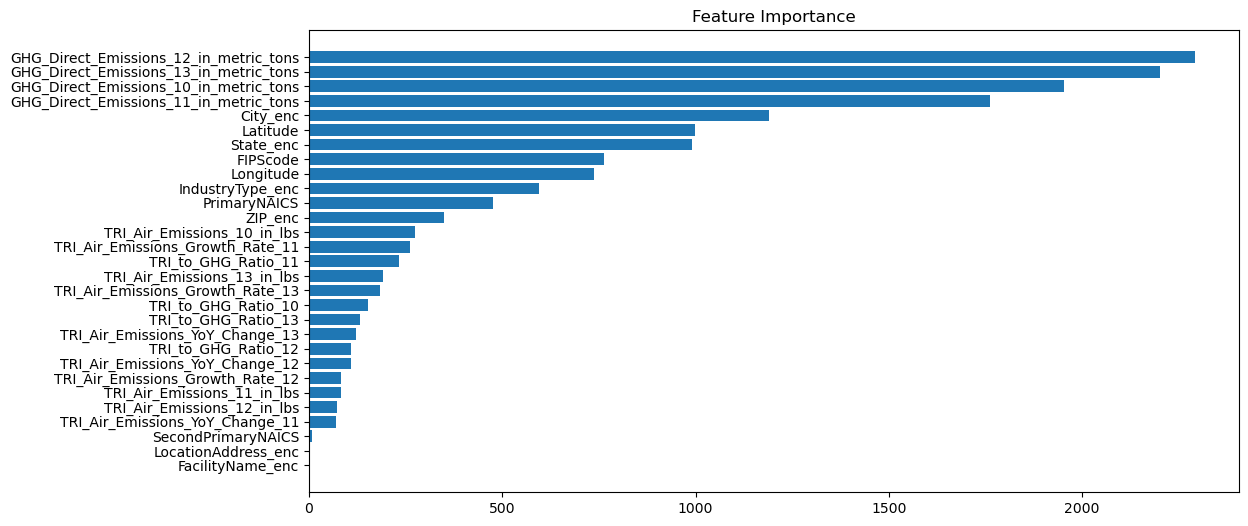

In [ ]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, numerical_columns)

In [ ]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )